# Optimització - Linear regression

En estadística, la **regressió lineal** és un enfocament lineal per modelar la relació entre una resposta escalar (o variable dependent) i una o més variables explicatives (o variables independents).

En regressió lineal, les relacions es modelen mitjançant funcions lineals on els paràmetres del model s’estimen a partir de les dades. 
Aquests models s'anomenen models lineals. 

Suposem que treballem amb un conjunt de dades $ \{y_{i}, x_{i_1}, \ldots, x_{i_m} \}_{i = 1}^{n}$ de $n$ unitats. 

Un **model de regressió lineal** assumeix que la relació entre la variable dependent $y$ i el vector $p$ dels regressors $x$ és lineal. 
Així, el model pren la forma:
$${\displaystyle y_{i}=\beta _{0}+\beta _{1}x_{i_1}+\cdots +\beta _{p}x_{i_p},\qquad i=1,\ldots ,n,}$$

In [1]:
import autograd

In [2]:
from plot_utils import *

import autograd.numpy as np
from autograd import elementwise_grad as grad, value_and_grad
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import random

from IPython.display import display

%matplotlib inline

No es permet l'ús de cap llibreria o funció que no estigui ja importat, sigui aquí o més abaix en el notebook.

## AutoGrad

En la part anterior, donada una funció havíem de definir també la funció que retorna el seu gradient.

En aquesta pràctica, però, veurem que mitjançant l'ús de la llibreria **AutoGrad**, això no és necessari.

Consideren les següents funcions:

In [3]:
def f1(x):
    return x**2

def f2(x):
    x, y = x[0], x[1]
    return x**2 + y**2

def f3(x):
    x, y, z = x[0], x[1], x[2]
    return (100 * (y - x**2)**2 + (1 - x)**2) + (100 * (z - y**2)**2 + (1 - y)**2)

Donada la funció `f1`, podem fàcilment derivar el seu gradient, que és $2x$.

Definim-lo manualment:

In [4]:
def grad_f1_manual(x):
    return 2*x

Ara, obtinguem la funció gradient a partir d'autograd:

In [5]:
grad_f1 = grad(f1)

Podem comprovar que **les dues donen el mateix valor de gradient evaluat en un punt $x$**.

In [6]:
x0 = np.asarray([1023.0])
print('Calcul manual gradient: df1\'(x0) = {}'.format(grad_f1_manual(x0)[0]))
print('Autograd: df1\'(x0) = {}'.format(grad_f1(x0)[0]))

assert np.allclose(grad_f1_manual(x0), grad_f1(x0)) 

Calcul manual gradient: df1'(x0) = 2046.0
Autograd: df1'(x0) = 2046.0


També podem utilitzar `value_and_grad` per obtenir directament amb la **imatge de la funció i el seu gradient en un punt $x$**:

In [7]:
val_grad_f1 = value_and_grad(f1)
print(val_grad_f1(x0))

value, gradient = val_grad_f1(x0)
assert np.allclose(value, f1(x0))
assert np.allclose(gradient, grad_f1(x0))

(array([1046529.]), array([2046.]))


Inclús podem aplicar `grad` sobre un altre `grad` per obtenir la 2a derivada (o Hessià en multiples dimensions).

In [8]:
grad_f1 = grad(f1) # df(x) = 2 * x
grad2_f1 = grad(grad_f1) # d2f(x) = 2

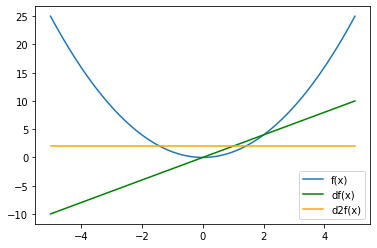

In [9]:
x = np.linspace(-5, 5, 100)
plt.plot(x, f1(x), label = 'f(x)')
plt.plot(x, grad_f1(x), color='green', label = 'df(x)')
plt.plot(x, grad2_f1(x), color='orange', label = 'd2f(x)')
plt.legend()

## Descens del gradient

**El primer pas serà implementar la mateixa funció `gradient_descend` que havieu fet en la part anterior, però ara mitjançant l'ús de la llibreria `autograd` i fent-la multidimensional.**

Aquesta funció hauria d'executar sense problemes, i donar el mínim, per les tres funcions `f1`, `f2` i `f3` definides més adalt, de 1, 2 i 3 dimensions respectivament. Però, també haurà de funcionar per les següents parts de la pràctica, amb 100 o més dimensions.

In [ ]:
def gradient_descend(f, x0, alpha, eps=1e-6, max_iter=1000, print_iters=1000):
    """
    Aquesta funció implementa l'algorisme de descens pel gradient, és a dir,
    donat un punt inicial, la funció de la que calculem el gradient i el pas, 
    intenta trobar el mínim de la funció seguint el gradient en direcció oposada.
    
    Pel criteri d'aturada, considerarem si ||x^{k+1} - x^k|| < eps, és a dir
    si la norma de la diferència és més petita que eps.
    
    Cada print_iters cal mostrar el resultat actual en la següent forma:
        "{}/{:.2f}".format(human_format(itr), float(valor_de_f_en_x))
    
    :param f: Funció a minimitzar
    :param x0: Punt inicial
    :param alpha: Pas de cada iteració
    :param eps: Moviment mínim realitzat abans de parar
    :param max_epochs: Iteracions màximes a realitzar
    :param print_iters: Numero d'iteracions per printar resultats
    :return: La funció retornarà el punt on es troba el mínim
    """
    
    # AQUÍ EL TEU CODI

Busquem el mínim de cadascuna de les funcions:

In [ ]:
x0 = np.array([4.0])
xm = gradient_descend(f1, x0, 0.01, 1e-6, 10000) # ~ @1s
print(f'f1({xm}) = {f1(xm)}')

In [ ]:
x0 = np.array([4.0, 5.1])
xm = gradient_descend(f2, x0, 0.01, 1e-6, 10000) # ~ @2s
print(f'f2({xm}) = {f2(xm)}')

In [ ]:
x0 = np.array([4.0, 5.1, 4.4])
xm = gradient_descend(f3, x0, 0.0001, 1e-6, 50000) # ~ @35s
print(f'f3({xm}) = {f3(xm)}')

## Linear regression

Cas simple: **Donat un conjunt de punts (X, Y) 2D, podem trobar la recta que minimitza la distància entre aquesta i tots els punts?**

Recordatori: 

Per tal de definir una recta necesitem dos punts $(x_0, y_0)$ i $(x_1, y_1)$. A partir d'aquests dos punts podem definir la recta com:

$$y={\frac {y_{1}-y_{0}}{x_{1}-x_{0}}} (x-x_{0}) +y_{0} = m \cdot x + n$$

In [ ]:
# Lectura de les dades
df = pd.read_csv('data/slr05.csv', index_col=0)
display(df.head())

# Visualització de les dades
plt.figure(figsize = (10, 10))
plt.scatter(df['X'], df['Y'])
plt.xlabel('Fires per 1000 housing units')
plt.ylabel('Thefts per 1000 population')
plt.title('Fire and Theft in Chicago')

# Possibles linies
# Parametres plt.plot: (x0, x1), (y0, y1)
plt.plot((0, 40), (0, 140), color='#ff0000')
plt.plot((0, 40), (0, 120), color='#ff0000')
plt.plot((0, 40), (10, 110), color='#ff0000')
plt.plot((0, 40), (20, 70), color='#ff0000')

plt.show()

Per ara, donat que estem a 2D, podem visualitzar l'error, és a dir la distància respecte aquesta línia. Però tot i així és impossible que poguem visualitzar, d'entre les infinites línies possibles, la que s'ajusta millor a les dades.

**Necessitem un algorisme que la trobi automàticament,** però primer visualitzem l'error de cadascuna de les anteriors rectes:

In [ ]:
for x1, y1, y0 in ((40, 140, 0), (40, 120, 0), (40, 110, 10), (40, 70, 20)):
    
    plt.figure()
    # Visualització de les dades
    plt.scatter(df['X'], df['Y'])
    plt.xlabel('Fires per 1000 housing units')
    plt.ylabel('Thefts per 1000 population')
    plt.title(f'Fire and Theft in Chicago, y = {y0} + x * {(y1 - y0) / x1:.2f}')

    # Visualització de la recta
    plt.plot((0, x1), (y0, y1), color='#ff0000')

    # Definció de la recta
    f = lambda x: (y1 - y0) / x1 * x + y0

    # Visualització de l'error per cada punt
    for _, (x, y) in df.iterrows():
        y_pred = f(x)
        plt.plot((x, x), (y, y_pred), color='b', alpha=0.2)

**Com definim un model que automàticament trobi aquesta línia?**

Primer de tot, assumim que nosaltres tenim unes dades de les quals dispossem els valors de $x$ i els corresponents valors de $y$. Per exemple, les dades anteriors.

1. Necessitem definir matemàticament una recta
$$ r: \hat{y} = m \cdot x + n $$
On $x$ és un punt que volem evaluar, $\hat{y}$ és la imatge obtinguda en el punt $x$, i $m$, $n$ són els paràmetres que defineixen la recta. Idealment, voldríem trobar aquelles $m$, $n$ que, per tot punt $x$ tinguéssim una $\hat{y}$ tal que $\hat{y}=y$.

2. Hem de mesurar l'error que estem cometent cada cop que provem una $m$, $n$ diferents (al que anomenarem *loss* del model). Per exemple, podríem definir l'error com a la distància entre el punt $y$ que hauria de ser i el $\hat{y}$ que ens dona el model:
$$\mathbb{L} = \sqrt{(y - \hat{y})^2}$$

3. Ara el que volem fer és trobar els valors de $m$, $n$ tal que $\mathbb{L}=0$. Si parem atenció a la funció definida per $\mathbb{L}$, veurem que efectivament $0$ és el mínim d'aquesta. Per tant, tot el que hem de fer és minimitzar la funció definida per
$$\mathbb{L} = \sqrt{(y - (m \cdot x + n))^2}$$

Per simplificar una mica el problema, unirem les variables que volem optimitzar $m,n$ en una de sola: $w$. Per fer-ho, expandirem la fòrmula anterior a:
$$\tilde{x} = (1, x), w = (n, m)$$

$$\mathbb{L} = \sqrt{(y - \tilde{x} \cdot w)^2}$$

On $\tilde{x}$ és un vector format per un $1$ i a continuació el valor de $x$ original. De forma que $\tilde{x} \cdot w = (1, x) \cdot (n, m) = n + x\cdot m = m\cdot x + n$ (producte escalar).

In [ ]:
def add_bias(X):
    """
    Funció que donada el vector x crea el vector x', afegint una columna d'1's al davant.
    Per exemple, si X és
        [
            [1, 2, 5, 1, 5, 7],
            [9, 4, 2, 4, 6, 1],
            ...
            [5, 3, 1, 4, 5, 7]
        ]
    El retorn de la funció serà la matriu
        [
            [1, 1, 2, 5, 1, 5, 7],
            [1, 9, 4, 2, 4, 6, 1],
            ...
            [1, 5, 3, 1, 4, 5, 7]
        ]
    
    *Sense bucles*
    
    :param X: Matriu on cada fila és una dada i cada columna una característica
    :return: Mateixa matriu amb una columna de 1s davant
    """
    # AQUÍ EL TEU CODI


def linear_regression(x, w):
    """
    Donat un punt i els parameters del model prediu el valor, implementant el càlcul de
    la regressió linial:
            y' = w0 * x0 + w1 * x1 + ... + xp * wp
            
    *Sense bucles*
    
    :param x: Matriu de dades i features, on la primera columna son 1s, té per shape [NDades, NFeatures]
    :param w: Matriu de paràmetres, té per shape [1, NFeatures]
    :return: Vector de tamany [NDades] amb la predicció y' per a cada punt
    """
    # AQUÍ EL TEU CODI

def loss(y_true, y_pred):
    """
    Funció que calcula la diferència entre la solució real i la predita mitjançant
    distància euclidea
        ||y_true - y_pred||
        
    :param y_true: Valor real de la Y
    :param y_pred: Valor predit y' per a cada corresponent y
    :return: Error de la predicció
    """
    # AQUÍ EL TEU CODI

def model(w, x, y):
    """
    Funció que genera el model que volem optimizar, calculant l'error d'una
    predicció amb els pàrametres i valors passats
    
    :param w: Paràmetres del model
    :param x: Dades del model
    :param y: Valors a predir
    :return: Error (loss) de les preddiccions
    """
    # AQUÍ EL TEU CODI

Generem les dades que utilitzarem per entrenar el model (*X_fire*) i les seves etiquetes (*Y_fire*).

In [ ]:
X_fire = df['X'].values[:, np.newaxis]
X_fire = add_bias(X_fire)

Y_fire = df['Y'].values

Per optimizar el model, necesitem initcialitzar els seus pesos amb valors random.

In [ ]:
# Parametres per defecte del model
w0 = np.random.normal(size=(1, X_fire.shape[1]))

# Optimització del model
wf_fire = gradient_descend(lambda w: model(w, X_fire, Y_fire), 
                           w0, 0.001, 
                           max_iter=20000, print_iters=1000) # ~ @5s
print(wf_fire)

In [ ]:
wf_fire.shape

Visualització de la recta obtinguda amb el model i els errors de les seves prediccions.

In [ ]:
plt.figure()
# Visualització de les dades
plt.scatter(df['X'], df['Y'])
plt.xlabel('fires per 1000 housing units')
plt.ylabel('thefts per 1000 population')
plt.title('Fire and Theft in Chicago')

# Visualització de la recta
# Parametres plt.plot: (x0, x1), (y0, y1)
plt.plot((0, 40), (wf_fire[0, 0], linear_regression((1, 40), wf_fire)), color='#ff0000')

# Visualització de l'error a cada punt
for _, (x, y) in df.iterrows():
    y_pred = linear_regression((1, x), wf_fire)
    plt.plot((x, x), (y, y_pred), color='b', alpha=0.2)

y_fire_pred = linear_regression(X_fire, wf_fire)
print('Mean error: {:.2f}'.format(np.mean(np.abs(Y_fire - y_fire_pred))))

## Linear regression amb polinomis

Imagineu que la nostra variable $x$ ara l'elevèssim a més potències:
$x, x^2, x^3, ...$

La fòrmula de linear regression quedaria:

$$ r: \hat{y} = m_1 \cdot x + m_2 \cdot x^2 + m_3 \cdot x^3 + ... + n $$

Fixeu-vos que llavors estem aprenent un polinomi per modelar la "recta" de predicció.

Com un polinomi de grau $k$ inclou tots els possibles polinomis de grau $k-1$, els resultats només poden millorar. Provem-ho:

In [ ]:
# Definim una funció per normalitzar per columnes (Obtenim una distribució Normal)
normalize = lambda x: (x - np.mean(x)) / np.std(x)

In [ ]:
for i in range(1, 5 + 1):
    def preprocess(x):
        # Calcularem totes les potències fins a i, i les ajuntarem totes en la dimensió 1
        x = np.concatenate([
            x ** j
            for j in range(1, i + 1)
        ], axis = 1)
        
        # Normalitzeu les dades! Sense no entrenarem bé (proveu-ho).
        x = normalize(x)
        
        return x
    
    X_fire = df['X'].values[:, np.newaxis]
    X_fire = preprocess(X_fire)
    X_fire = add_bias(X_fire)
    Y_fire = df['Y'].values
    
    print(X_fire.shape)
    
    # Parametres per defecte del model
    w0 = np.random.normal(size=(1, X_fire.shape[1]))

    # Optimització del model
    wf_fire = gradient_descend(lambda w: model(w, X_fire, Y_fire), 
                               w0, 0.001, 
                               max_iter=20000, print_iters=1000) # ~ @5s
    print(wf_fire)
    
    y_fire_pred = linear_regression(X_fire, wf_fire)
    error = np.mean(np.abs(Y_fire - y_fire_pred))
    print(f'Mean error {i}: {error:.2f}\n')

Hem transformat un mètode simplement lineal en un polinomi, només afegint noves columnes amb transformacions de les dades.

D'això se'n diu fer **feature engineering**: fem modificacions "intel·ligents" sobre les columnes del dataset per permetre'ns obtenir models més potents. 

Aquí ens hem limitat a fer potències de x, però podriem fer exponencials, logaritmes, talls binaris (x > 25 -> 1, x <= 25 -> 0), etc.

Ara, torneu a implementar el mètode preprocess, fent que la matriu resultant tingui:

* x (sense cap modificació)
* $e^x$
* $\log x$ (això ho podem fer perquè en aquest dataset, x > 0 sempre)
* $x > \overline{x}$, on $\overline{x}$ és la mitja de x.

*No us oblideu de normalitzar!*


**Justifica el resultat obtingut en aquest cas.**

<hr />

* RECORDA JUSTIFICAR LA RESPOSTA

<hr />

In [ ]:
def preprocess(x):
    
    # AQUÍ EL TEU CODI

    return x

X_fire = df['X'].values[:, np.newaxis]
X_fire = preprocess(X_fire)
X_fire = add_bias(X_fire)
Y_fire = df['Y'].values

print(X_fire.shape)

# Parametres per defecte del model
w0 = np.random.normal(size=(1, X_fire.shape[1]))

# Optimització del model
wf_fire = gradient_descend(lambda w: model(w, X_fire, Y_fire), 
                           w0, 0.001, 
                           max_iter=20000, print_iters=1000) # ~ @5s
print(wf_fire)

y_fire_pred = linear_regression(X_fire, wf_fire)
error = np.mean(np.abs(Y_fire - y_fire_pred))
print(f'Mean error {i}: {error:.2f}')

## Dades multidimensionals sobre les dades

En l'apartat anterior tenim un sol valor de $x$ pel qual volíem obtenir un valor de $y$, però en la gran majoria de casos no serà així.

En aquest apartat volem trobar una regressió lineal tal que $dim(X) = 6$, i per tant necessitem un total de 7 paràmetres ($dim(w) = 7$)

In [ ]:
# Lectura de les dades
dg = pd.read_csv('data/mlr10.csv', index_col=0)
Y_pop = dg.values[:, 0]
X_pop = dg.values[:, 1:]
X_pop = add_bias(X_pop)
display(dg.head())

In [ ]:
# Parametres per defecte del model
w0 = np.random.normal(size=(1, X_pop.shape[1]))

# Optimització del model
wf_population = gradient_descend(lambda w: model(w, X_pop, Y_pop), w0, 0.001, max_iter=100000, print_iters=1000) # ~ @20s
print(wf_population)

In [ ]:
# Utilitzant els paràmetres apresos, obtenim la predicció per a cada punt
y_pop_pred = linear_regression(X_pop, wf_population)

In [ ]:
# Visualització de les dades originals i les prediccions
plt.figure(figsize=(20, 3))
plt.scatter(range(Y_pop.shape[0]), Y_pop, color='green', label = 'y')
plt.scatter(range(Y_pop.shape[0]), y_pop_pred, color='red', label = 'y_pred')
plt.xlabel('Samples')
plt.ylabel('Total population')
plt.legend()

for x in range(X_pop.shape[0]):
    plt.plot((x, x), (0, 20), '-.', color='gray', alpha=0.2)

print('Mean error: {:.2f}'.format(np.mean(np.abs(Y_pop - y_pop_pred))))

**Feu feature engineering** vosaltres mateixos i intenteu aconseguir que la vostra loss sigui **inferior a 0.5**.

Podeu canviar els valors d'entrenament (canviar el nombre d'epochs, o el learning rate lr), <br />
tot i que els valors establerts (```n_epochs=10000, lr=1e-3```) ja us poden donar el resultat esperat.

Idees:

* Feu servir les potències de cada columna de x.
* Penseu si ajuda o no normalitzar abans de fer cap modificació.
* Proveu a afegir algunes funcions diferents (log, exp, binarització...).
* Combinacions.


**Combinacions**:

Tenim 6 columnes d'input. Les tres primeres millores utilitzen transformacions que només aprofiten cada columna per separat ($X_1^3$, $X_2^3$, etc.)

Però què passa si "barregem" columnes, fent que el model pugui aprofitar les interaccions entre elles?

Per exemple, podriem afegir les columnes $X_1 \cdot X_2, X_1 \cdot X_3, ..., X_5 \cdot X_6$.

Això serien les combinacions de 2 elements. I de 6 elements?

$X_1 \cdot X_2 \cdot X_3 \cdot X_4 \cdot X_5 \cdot X_6$.

**Veieu si ajuda, i com, aquest afegit. Comenteu els resultats obtinguts.**

<hr />

* RECORDA JUSTIFICAR LA RESPOSTA

<hr />


In [ ]:
from itertools import combinations

In [ ]:
def preprocess(x):
    
    # AQUÍ EL TEU CODI

    return x


X_pop = dg.values[:, 1:]
X_pop = preprocess(X_pop)
X_pop = add_bias(X_pop)
Y_pop = dg.values[:, 0]

print(X_pop.shape)

# Parametres per defecte del model
w0 = np.random.normal(size=(1, X_pop.shape[1]))

# Optimització del model
wf_pop = gradient_descend(lambda w: model(w, X_pop, Y_pop), 
                           w0, 0.001, 
                           max_iter=20000, print_iters=1000) # ~ @5s
print(wf_pop.shape)

y_pop_pred = linear_regression(X_pop, wf_pop)
error = np.mean(np.abs(Y_pop - y_pop_pred))
print(f'Mean error: {error:.2f}')

## Airbnb: dades reals (a baixa escala)

**Airbnb Dataset**

Les dades amb les que treballarem en aquesta pràctica són dades reals recopilades per *Airbnb*. 
Aquestes analitzen la informació disponible sobre els llistats d’Airbnb d’una ciutat, proporcionant filtres i mètriques clau perquè pugueu veure com Airbnb s’utilitza per competir amb el mercat d’habitatges residencials.

Amb aquestes dades podrieu fer preguntes fonamentals sobre Airbnb a qualsevol barri o a tota la ciutat. Preguntes com:

- "Quants fitxes hi ha al meu barri i on són?"
- "Quantes cases i apartaments es lloguen amb freqüència a turistes i no a residents a llarg termini?"
- "Quant costen els hostes des del lloguer als turistes (compareu-ho amb els lloguers a llarg termini)?"
- "Quins amfitrions tenen una empresa amb diversos llistats i on?"

Les dades inclou dades com:
- Quantitat de nits que es lloga una vivenda a l'any.
- Estades mínimes.
- Quantes habitacions es lloguen en un edifici.
- Nombre d’ocupats permesos en un lloguer.

En el nostre cas, **volem predir el preu de la vivenda utilitzant les dades numèriques.**

In [ ]:
df_airbnb = pd.read_csv('data/clean_scraping.csv', index_col = 'Unnamed: 0')

In [ ]:
display(df_airbnb.head())

In [ ]:
df_airbnb.shape

In [ ]:
df_airbnb.columns

A la variable *y_true* guardarem la variable que volem predir amb el nostre model lineal.

In [ ]:
y_true = df_airbnb.price

Definim ara quina és la informació que utilitzarem per fer la predicció.

Com hem vist abans, algunes variables no són numèriques, per tant cal fer una conversió de la informació.

In [ ]:
X = df_airbnb[['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]

In [ ]:
cleanup_columns = { 'neighbourhood_group': { name: idx for idx, name in enumerate(X.neighbourhood_group.unique())},
                    'neighbourhood': { name: idx for idx, name in enumerate(X.neighbourhood.unique())},
                    'room_type': { name: idx for idx, name in enumerate(X.room_type.unique())},
                  }

In [ ]:
X = X.replace(cleanup_columns).values

No ens oblidem de normalitzar les dades abans de passar-les a LinearRegression!

In [ ]:
X = (X - X.mean(0)) / X.std(0)

Un cop netejades les dades, separarem un conjunt de les dades. 

### Partició de dades

En l'aprenentatge automàtic, una tasca habitual és l'estudi i la construcció d'algorismes que poden aprendre i fer prediccions sobre dades. Aquests algoritmes funcionen fent prediccions o decisions basades en dades, mitjançant la creació d'un model matemàtic a partir de dades d'entrada.

Les dades que s’utilitzen per construir el model final normalment provenen de múltiples conjunts de dades. En particular, dos conjunts de dades s’utilitzen habitualment en diferents etapes de la creació del model: dades d'entrenament (train) i de prova (test).

El model s’adapta inicialment a un conjunt de dades d’entrenament, que és un conjunt d’exemples que s’utilitzen per ajustar els paràmetres (per exemple, pesos del model de regressió linal) del model. 
El model es forma en el **conjunt de dades d’entrenament** que sovint consisteix en parells d’un vector d’entrada (o escalar) i el vector de sortida corresponent (o escalar), que es denomina habitualment com a objectiu (o etiqueta). El model actual s'executa amb el conjunt de dades d'entrenament i produeix un resultat, que es compara després amb l'objectiu, per a cada vector d'entrada del conjunt de dades d'entrenament. A partir del resultat de la comparació i de l'algorisme d'aprenentatge específic que s'utilitza, s'ajusten els paràmetres del model. L'adaptació del model pot incloure selecció de variables i estimació de paràmetres.

El **conjunt de dades de prova** és un conjunt de dades utilitzat per proporcionar una avaluació imparcial d’un model. Si les dades de prova no s’han utilitzat mai durant l'entrenament, el resultats representa el comportament esperat del model.

A continuació heu d'implementar la funció *split* que crea aquesta partició de dades.

In [ ]:
def split(X, Y, train_percent, random_seed=None):
    """
    Divideix el conjunt de dades en dos subconjunts aleatoris diferents, sense
    intersecció.
    La divisió es fa conjuntament en X i Y, és a dir, donat una dada x de X,
    la seva corresponent y en Y es troba en el mateix conjunt
    X = [[1, 2, 3], [2, 3, 1], ..., [1, 4, 5]]
    Y = [1, 2, ..., 5]
    
    Train: X = [[1, 2, 3], [1, 4, 5]]; Y = [1, 5]
    Test:  X = [[2, 3, 1]]; Y = [2]
    
    :param X: Dades del model
    :param Y: Corresponents valors a predir
    :param train_percent: Percentatge entre 0 i 1, indicant el nombre
        d'elements que contindrà el conjunt de train
    :param random_seed: En cas de que sigui necessari (no és obligatori fer-ho servir), 
        per fixar el comporament de random
    :return: Una llista/tupla que contingui, en aquest ordre, 
        * Conjunt train X [NDadesTrain, NFeatures]
        * Conjunt test X [NDadesTest, NFeatures]
        * Conjunt train Y [NDadesTrain]
        * Conjunt test Y [NDadesTest]
    """
    # AQUÍ EL TEU CODI

Abans de generar els conjunts d'entrenament i prova cal generar els vectors que representen cada entrada de les dades.

In [ ]:
# Valors amb els que predirem el preu de la vivenda
X = add_bias(X)

# Valors reals de la vivenda
Y = df_airbnb['price'].values

# Partim en train i test
X_train, X_test, Y_train, Y_test = split(X, Y, train_percent=0.80)

In [ ]:
# Parametres per defecte del model
w0 = np.random.normal(size=(1, X.shape[1]))

# Optimització del model sobre train
wf = gradient_descend(lambda w: model(w, X_train, Y_train), w0, 0.01, max_iter=5000, print_iters=100) # ~ @2min

# Realitzem la predicció sobre test
y_pred = linear_regression(X_test, wf)
y_pred = np.maximum(np.min(Y), y_pred)

In [ ]:
# Mostrem únicament 100 dades en el gràfic
size = 100
sample = np.random.choice(X_test.shape[0], size=size, replace=False)

# Mínima i màxima Y a mostrar en el gràfic
miny = np.minimum(y_pred[sample].min(), Y_test[sample].min()) - 10
maxy = np.maximum(y_pred[sample].max(), Y_test[sample].max()) + 1e3

# Visualització de les dades originals i les prediccions
plt.figure(figsize=(20, 3))
plt.scatter(range(size), Y_test[sample], color='green', label = 'price')
plt.scatter(range(size), y_pred[sample], color='red', label = 'pred_price')
plt.xlabel('100 random samples')
plt.ylabel('Total population (log scale)')
plt.yscale('symlog')
plt.ylim([miny, maxy])
plt.grid(axis='y', which='minor', alpha=0.2)
plt.grid(axis='y', which='major', alpha=0.3)
plt.legend()

for x in range(size):
    plt.plot((x, x), (miny, maxy), '-.', color='gray', alpha=0.2)

print('Mean error: {:.2f}'.format(np.mean(np.abs(Y_test - y_pred))))

## Impacte de les dimensions del vector de característiques sobre una regressió lineal

**Explorem com l'ús de més o menys informació impacta sobre el model.**

**És possible obtenir un millor model amb menys dades?**

<hr />

* RECORDA JUSTIFICAR LA RESPOSTA

<hr />

In [ ]:
# AQUÍ EL TEU CODI